# **은행 예금 상품 가입 여부 예측 모델**

### 1. 소스코드와 학습한 모델을 저장하여 제출한다.
- 소스코드 : 홍길동.ipynb
- 모델명 : 홍길동.md
### 2. 3번 테스트하여 가장 좋은 결과를 점수로 채택한다.

### 3. 피쳐는 최소 3개 이상 사용한다.

### 4. 제출 일자 ~목요일 오후4시50분

**변수**
- age: 나이(19살이하, 초과 or 컬럼 제외)
- job: 직업 정보(범주형)
- marital: 결혼 정보
- education: 교육 정도
- default: 채무 불이행 여부
- balance: 일년 평균 잔고
- housing: 주택담보 대출이 있는지 여부
- loan: 대출여부
- contact: 통신 방법 (필요없지 않나?)
- 
- day: 고객과 마지막으로 연락된 일
- month: 고객과 마지막으로 연락된 달
- duration: 고객과 통화 시간 (초 단위)
- 
- campaign: 고객과 마지막 접촉을 포함한 접촉 횟수
- pdays: 지난 캠페인 이후의 연락하는데 걸린 기간 (-1일 경우 연락 못 함)
- previous: 캠패인 전 고객과 연락한 횟수
- poutcome: 지난번 마케팅 캠페인의 결과
- y: 고객의 정기예금 여부

In [34]:
import pandas as pd

file_path = 'bank-full.csv'
df = pd.read_csv(file_path, sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### 결측치는 없음 !!!

In [36]:
value_counts_col = {col: df[col].value_counts() for col in df.columns}

value_counts_col

{'age': 32    2085
 31    1996
 33    1972
 34    1930
 35    1894
       ... 
 93       2
 90       2
 95       2
 88       2
 94       1
 Name: age, Length: 77, dtype: int64,
 'job': blue-collar      9732
 management       9458
 technician       7597
 admin.           5171
 services         4154
 retired          2264
 self-employed    1579
 entrepreneur     1487
 unemployed       1303
 housemaid        1240
 student           938
 unknown           288
 Name: job, dtype: int64,
 'marital': married     27214
 single      12790
 divorced     5207
 Name: marital, dtype: int64,
 'education': secondary    23202
 tertiary     13301
 primary       6851
 unknown       1857
 Name: education, dtype: int64,
 'default': no     44396
 yes      815
 Name: default, dtype: int64,
 'balance':  0        3514
  1         195
  2         156
  4         139
  3         134
           ... 
 -381         1
  4617        1
  20584       1
  4358        1
  16353       1
 Name: balance, Length: 7168, dtype

In [37]:
df[['loan', 'housing']].value_counts() # 두 변수 간 큰 상관관계는 없음

loan  housing
no    yes        20763
      no         17204
yes   yes         4367
      no          2877
dtype: int64

In [38]:
# Step 1: Check data types
data_types = df.dtypes

# Step 2: Check the number of unique values for each column
unique_counts = df.nunique()

# Combine results into a single DataFrame for easier interpretation
categorical_check = pd.DataFrame({
    'DataType': data_types,
    'UniqueValues': unique_counts
}).sort_values(by='UniqueValues', ascending=True)

categorical_check

,DataType,UniqueValues
y,object,2
loan,object,2
housing,object,2
default,object,2
contact,object,3
marital,object,3
poutcome,object,4
education,object,4
job,object,12
month,object,12


1. 제거 고려 대상
(1) 목표와 직접 관련 없는 변수 (contact, day, month)

(2) 정보가 부족한 변수 (default)

(3) 중복적 정보
housing과 loan: 두 변수가 고객의 대출 관련 정보를 중복적으로 나타내는 경우가 있으므로 상관분석 후 하나를 선택.

(4) 고차원 연속형 변수
pdays: 과거 마케팅 연락 이후 경과 일수로, 값이 다양하며, 실제로 유의미하지 않을 가능성 있음.

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'y' to numeric for better visualization (yes=1, no=0)
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)


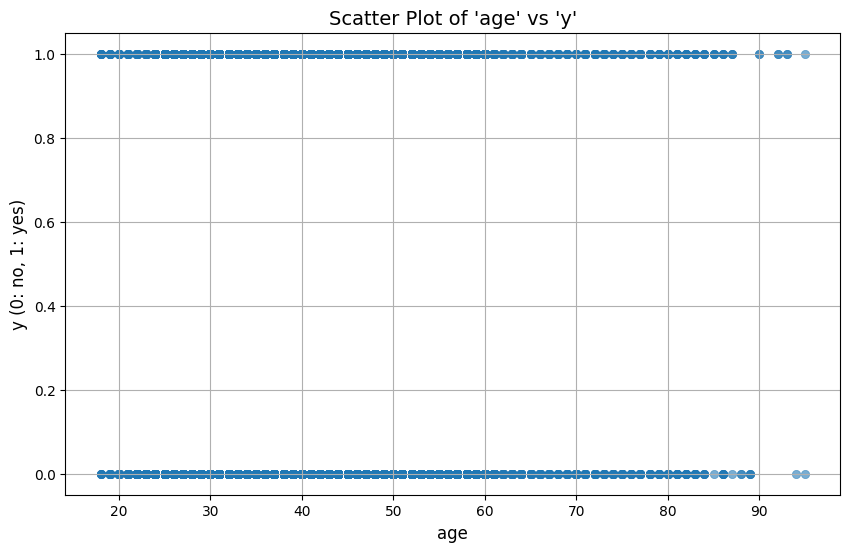

In [40]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='y', data=df, alpha=0.6, edgecolor=None)
plt.title("Scatter Plot of 'age' vs 'y'", fontsize=14)
plt.xlabel('age', fontsize=12)
plt.ylabel('y (0: no, 1: yes)', fontsize=12)
plt.grid(True)
plt.show()

### pdays는 종속변수와 유의미한 관계가 없다고 보여짐.

In [41]:
df = df.drop(['day', 'month', 'contact', 'default', 'pdays'], axis = 1)

In [42]:
# 원핫 인코딩할 열을 지정
columns_to_encode = ['marital', 'poutcome', 'education', 'job']  # 원하는 컬럼명 리스트

# 지정한 열만 원핫 인코딩
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False)

df.head()

,age,balance,housing,loan,duration,campaign,previous,y,marital_divorced,marital_married,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,2143,yes,no,261,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,44,29,yes,no,151,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,2,yes,yes,76,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,47,1506,yes,no,92,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,33,1,no,no,198,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

loan_col = df['loan']
housing_col = df['housing']

le = LabelEncoder()
le.fit(loan_col)
le.fit(housing_col)
df['loan'] = le.transform(loan_col)
df['housing'] = le.transform(housing_col)

In [44]:
# 상관관계 확인
corr = df.corr()
print(corr['y'].sort_values(ascending=False))  # 'y'는 타겟 변수

y                      1.000000
duration               0.394521
poutcome_success       0.306788
previous               0.093236
job_retired            0.079245
job_student            0.076897
education_tertiary     0.066448
marital_single         0.063526
balance                0.052838
job_management         0.032919
poutcome_other         0.031955
age                    0.025155
job_unemployed         0.020390
education_unknown      0.012053
poutcome_failure       0.009885
job_admin.             0.005637
marital_divorced       0.002772
job_self-employed      0.000855
job_unknown            0.000267
job_technician        -0.008970
job_housemaid         -0.015195
job_entrepreneur      -0.019662
job_services          -0.027864
education_secondary   -0.036388
education_primary     -0.040393
marital_married       -0.060260
loan                  -0.068185
job_blue-collar       -0.072083
campaign              -0.073172
housing               -0.139173
poutcome_unknown      -0.167051
Name: y,

In [45]:
low_corr_features = corr['y'][abs(corr['y']) < 0.09].index

print("상관계수 0.09 이하의 변수:", low_corr_features)

# 변수 제거
dropped_df = df.drop(columns=low_corr_features)

dropped_df

상관계수 0.09 이하의 변수: Index(['age', 'balance', 'loan', 'campaign', 'marital_divorced',
       'marital_married', 'marital_single', 'poutcome_failure',
       'poutcome_other', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown'],
      dtype='object')


,housing,duration,previous,y,poutcome_success,poutcome_unknown
0,1,261,0,0,0,1
1,1,151,0,0,0,1
2,1,76,0,0,0,1
3,1,92,0,0,0,1
4,0,198,0,0,0,1
...,...,...,...,...,...,...
45206,0,977,0,1,0,1
45207,0,456,0,1,0,1
45208,0,1127,3,1,1,0
45209,0,508,0,0,0,1


In [46]:
target = df['y']

In [47]:
df = df.drop('y', axis = 1)

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, target,
                                                    test_size = 0.3, random_state = 42)

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_test)
X_test = scaler.transform(X_test)
scaler.fit(df)
df = scaler.transform(df)

In [50]:
X_train.shape, y_test.shape

((31647, 30), (13564,))

In [51]:
y_test.value_counts()

0    11966
1     1598
Name: y, dtype: int64

In [52]:
from sklearn.linear_model import LogisticRegression

model_log_reg = LogisticRegression(solver = "saga", class_weight='balanced', C = 0.02, penalty = 'l1')
model_log_reg.fit(X_train, y_train)

LogisticRegression(C=0.02, class_weight='balanced', penalty='l1', solver='saga')

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 하이퍼파라미터 그리드 설정
param_grid = {
    'C': [0.01, 0.02, 0.04, 0.08],
    'penalty': ['l1'],
    'solver': ['saga']
}

# GridSearchCV로 최적의 하이퍼파라미터 탐색
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", grid.best_params_)
print("최고 교차 검증 점수: ", grid.best_score_)


최적 하이퍼파라미터:  {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
최고 교차 검증 점수:  0.8318954774993216


In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 하이퍼파라미터 그리드 설정
param_grid = {
    'C': [0.1, 0.2, 0.3, 0.4],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# GridSearchCV로 최적의 하이퍼파라미터 탐색
grid = GridSearchCV(LogisticRegression(max_iter=70, class_weight='balanced'), param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", grid.best_params_)
print("최고 교차 검증 점수: ", grid.best_score_)


최적 하이퍼파라미터:  {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}
최고 교차 검증 점수:  0.8301260004038682


In [55]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

log_pred = model_log_reg.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, log_pred)

conf_mat = confusion_matrix(y_test, log_pred)
print(conf_mat)

train_accuracy = model_log_reg.score(X_train, y_train)
test_accuracy = model_log_reg.score(X_test, y_test)

print(f"훈련 데이터 정확도: {train_accuracy:.3f}")
print(f"테스트 데이터 정확도: {test_accuracy:.3f}")

print("정확도 no yes: \n   ", conf_mat[0][0] / conf_mat[0].sum(), conf_mat[1][1] / conf_mat[1].sum())

[[10044  1922]
 [  367  1231]]
훈련 데이터 정확도: 0.831
테스트 데이터 정확도: 0.831
정확도 no yes: 
    0.8393782383419689 0.7703379224030038


In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, f1_score, fbeta_score

estimator = DecisionTreeClassifier()
cv = KFold(n_splits = 10, random_state=42, shuffle=True)

# scorer = make_scorer(fbeta_score, beta=1.5, pos_label=1)
scorer = make_scorer(f1_score, pos_label=1)

parameters = {'max_depth' : [5, 6, 7, 8],
             'criterion' : ['gini'],
             'splitter' : ['best'],
             'min_samples_split' : [2],
             'min_samples_leaf' : [2, 3],
              'class_weight': ['balanced', {0 : 1, 1 : 3}],
             'max_leaf_nodes' : [12, 16, 20, 24]}

model = GridSearchCV(estimator = estimator, 
                    param_grid = parameters,
                    scoring = scorer,
                    cv = cv, verbose = 1,
                    n_jobs = -1, refit = True)

model.fit(X_train, y_train)

print("Best Estimator : \n", model.best_estimator_);print()
print("Best Params : \n", model.best_params_);print()
print("Best Score : \n", model.best_score_);print()

Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best Estimator : 
 DecisionTreeClassifier(class_weight={0: 1, 1: 3}, max_depth=8,
                       max_leaf_nodes=24, min_samples_leaf=2)

Best Params : 
 {'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 24, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}

Best Score : 
 0.5393856272161748



In [57]:
import numpy as np
import matplotlib.pyplot as plt

model_dt = DecisionTreeClassifier(criterion = 'gini',
                               max_depth = 8,
                               max_leaf_nodes = 24,
                               min_samples_leaf = 2,
                               min_samples_split = 2,
                               class_weight = {0 : 1, 1 : 4},
                               splitter = 'best')
model_dt.fit(X_train, y_train)
dt_pred = model_dt.predict(X_test)
conf_mat = confusion_matrix(y_test, dt_pred)
print(conf_mat)
print("정확도 no yes: \n   ", conf_mat[0][0] / conf_mat[0].sum(), conf_mat[1][1] / conf_mat[1].sum())
train_accuracy = model_dt.score(X_train, y_train)
test_accuracy = model_dt.score(X_test, y_test)
print(f"훈련 데이터 정확도: {train_accuracy:.3f}")
print(f"테스트 데이터 정확도: {test_accuracy:.3f}")

print("피처 중요도 : \n", model_dt.feature_importances_)

[[10170  1796]
 [  394  1204]]
정확도 no yes: 
    0.8499080728731405 0.753441802252816
훈련 데이터 정확도: 0.845
테스트 데이터 정확도: 0.839
피처 중요도 : 
 [0.05552249 0.0066382  0.072554   0.         0.57954104 0.01004165
 0.0263696  0.         0.         0.         0.         0.
 0.24487217 0.00446085 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [59]:
param_grid = {
    'n_estimators': [100, 120],
    'max_depth': [13, 15],
    'min_samples_split': [3, 4],
    'min_samples_leaf': [4, 5],
    'max_features': ['sqrt'],
    'class_weight' : ['balanced']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 120}


In [60]:
model_rf = RandomForestClassifier(class_weight = 'balanced', max_depth = 15,
                                  max_features = 'sqrt', min_samples_leaf = 4,
                                  min_samples_split = 4, n_estimators = 120)
model_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=4, min_samples_split=4,
                       n_estimators=120)

In [61]:
rf_pred = model_rf.predict(X_test)
conf_mat = confusion_matrix(y_test, rf_pred)
print(conf_mat)
print("정확도 no yes: \n   ", conf_mat[0][0] / conf_mat[0].sum(), conf_mat[1][1] / conf_mat[1].sum())

train_accuracy = model_rf.score(X_train, y_train)
test_accuracy = model_rf.score(X_test, y_test)
print(f"훈련 데이터 정확도: {train_accuracy:.3f}")
print(f"테스트 데이터 정확도: {test_accuracy:.3f}")

print("피처 중요도 : \n", model_rf.feature_importances_)

[[10307  1659]
 [  375  1223]]
정확도 no yes: 
    0.8613571786729066 0.7653316645807259
훈련 데이터 정확도: 0.882
테스트 데이터 정확도: 0.850
피처 중요도 : 
 [0.08386251 0.08066842 0.05608156 0.01232962 0.48743517 0.03658465
 0.04153771 0.00406017 0.01025592 0.00838731 0.00964598 0.00439657
 0.06438596 0.02790016 0.00584099 0.0066115  0.00925461 0.00264977
 0.00529257 0.0097742  0.00238408 0.00179536 0.00522591 0.0050334
 0.00224442 0.00364763 0.00514333 0.00498842 0.00200948 0.00057258]


In [62]:
# 클래스 가중치 설정
negative_count = (y_train == 0).sum()
positive_count = (y_train == 1).sum()
scale_pos_weight = negative_count / positive_count

In [63]:
from xgboost import XGBClassifier

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [90, 100],
    'learning_rate': [0.07, 0.08],
    'max_depth': [6, 7],
    'min_child_weight': [5],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0.07, 0.08]
}

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=XGBClassifier(scale_pos_weight=scale_pos_weight/1.5, random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters:", grid_search.best_params_)

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.08, 'learning_rate': 0.07, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


In [64]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(colsample_bytree = 0.8, gamma = 0.08, learning_rate = 0.07,
                          max_depth = 6, min_child_weight = 5, n_estimators = 130,
                          subsample = 0.8, scale_pos_weight=scale_pos_weight/1.5, random_state=42)

model_xgb.fit(X_train, y_train)

xgb_pred = model_xgb.predict(X_test)
conf_mat = confusion_matrix(y_test, xgb_pred)
print(conf_mat)
print("정확도 no yes: \n   ", conf_mat[0][0] / conf_mat[0].sum(), conf_mat[1][1] / conf_mat[1].sum())

train_accuracy = model_xgb.score(X_train, y_train)
test_accuracy = model_xgb.score(X_test, y_test)
print(f"훈련 데이터 정확도: {train_accuracy:.3f}")
print(f"테스트 데이터 정확도: {test_accuracy:.3f}")

print("피처 중요도 : \n", model_xgb.feature_importances_)

[[10032  1934]
 [  377  1221]]
정확도 no yes: 
    0.8383753969580477 0.7640801001251565
훈련 데이터 정확도: 0.868
테스트 데이터 정확도: 0.830
피처 중요도 : 
 [0.02250038 0.01563838 0.09530888 0.03262328 0.10185231 0.02151759
 0.03127465 0.00814479 0.01743498 0.02049033 0.01225797 0.01120127
 0.29708022 0.05496044 0.01798167 0.0086634  0.02092895 0.0105137
 0.01361392 0.03390295 0.01340181 0.00905197 0.01131202 0.01308556
 0.01301837 0.01618766 0.04163691 0.00985315 0.01353498 0.01102752]


In [65]:
from sklearn.svm import SVC

# 하이퍼파라미터 그리드 설정
param_grid = {
    'C': [0.05, 0.1],
    'kernel': ['rbf', 'poly'],
    'gamma': [0.001, 0.002],
    'class_weight': ['balanced']
}

# GridSearchCV 설정
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best parameters:", grid_search.best_params_)

KeyboardInterrupt: 

In [66]:
from sklearn.svm import SVC

model_svc = SVC(C = 0.1, class_weight = 'balanced',
                gamma = 0.001, kernel = 'rbf')
model_svc.fit(X_train, y_train)

svc_pred = model_svc.predict(X_test)
conf_mat = confusion_matrix(y_test, svc_pred)
print(conf_mat)
print("정확도 no yes: \n   ", conf_mat[0][0] / conf_mat[0].sum(), conf_mat[1][1] / conf_mat[1].sum())

train_accuracy = model_svc.score(X_train, y_train)
test_accuracy = model_svc.score(X_test, y_test)
print(f"훈련 데이터 정확도: {train_accuracy:.3f}")
print(f"테스트 데이터 정확도: {test_accuracy:.3f}")

[[10310  1656]
 [  428  1170]]
정확도 no yes: 
    0.8616078890188869 0.7321652065081352
훈련 데이터 정확도: 0.848
테스트 데이터 정확도: 0.846


In [ ]:
from sklearn.svm import SVC

model_svc = SVC(C = 0.1, class_weight = 'balanced',
                gamma = 0.002, kernel = 'rbf')
model_svc.fit(X_train, y_train)

svc_pred = model_svc.predict(X_test)
conf_mat = confusion_matrix(y_test, svc_pred)
print(conf_mat)
print("정확도 : ", conf_mat[0][0] / conf_mat[0].sum(), conf_mat[1][1] / conf_mat[1].sum())

train_accuracy = model_svc.score(X_train, y_train)
test_accuracy = model_svc.score(X_test, y_test)
print(f"훈련 데이터 정확도: {train_accuracy:.3f}")
print(f"테스트 데이터 정확도: {test_accuracy:.3f}")
print(classification_report(y_test, y_pred))

In [67]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Base Models
base_models = [
    ('rf', model_rf),
    ('xgb', model_xgb),
    ('svc', model_svc),
    ('dt', model_dt),
    ('log', model_log_reg)
]

# Meta Model

# Custom Scorer
f1_scorer = make_scorer(f1_score, pos_label=1)

meta_model = LogisticRegression(class_weight='balanced', random_state=42)

# 스태킹 분류기 정의
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model
)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'final_estimator__C': [0.01]  # 최종 로지스틱 회귀의 C 파라미터
}

# GridSearchCV 설정 (f1_score 사용)
grid = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_grid,
    scoring=f1_scorer,  # f1_score를 스코어로 설정
    cv=5,  # 5-폴드 교차 검증
    verbose=2,  # 진행 상황 표시
)

# 학습
grid.fit(X_train, y_train)

# 결과 출력
print("Best parameters found:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

# 최적 모델로 예측
# best_model = grid.best_estimator_
# y_pred = best_model.predict(X_test)

# # 최종 F1 스코어 확인
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ............................final_estimator__C=0.01; total time= 4.3min


KeyboardInterrupt: 

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
print("정확도 : ", conf_mat[0][0] / conf_mat[0].sum(), conf_mat[1][1] / conf_mat[1].sum())
print((conf_mat[0][0]+conf_mat[1][1]) / conf_mat.sum())

In [ ]:
from sklearn.metrics import precision_recall_curve

# Predict probabilities
y_pred_probs = best_model.predict_proba(X_test)[:, 1]

# Adjust threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
optimal_idx = np.argmax(2 * (precision * recall) / (precision + recall))
optimal_threshold = thresholds[optimal_idx]

# Final predictions
y_pred_adjusted = (y_pred_probs >= optimal_threshold*0.9).astype(int)

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred_adjusted)
print(conf_mat)
print("정확도 : ", conf_mat[0][0] / conf_mat[0].sum(), conf_mat[1][1] / conf_mat[1].sum())
print((conf_mat[0][0]+conf_mat[1][1]) / conf_mat.sum())

In [ ]:
import pickle

with open('model_rf.md', 'wb') as f:
    pickle.dump(model_rf, f)

with open('model_xgb.md', 'wb') as f:
    pickle.dump(model_xgb, f)

with open('model_svc.md', 'wb') as f:
    pickle.dump(model_svc, f)

with open('model_dt.md', 'wb') as f:
    pickle.dump(model_dt, f)

with open('model_log.md', 'wb') as f:
    pickle.dump(model_log_reg, f)

with open('best_model.md', 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
with open('best_model.md', 'rb') as f:
    model = pickle.load(f)

In [ ]:
y_pred = best_model.predict(X_test)

# 최종 F1 스코어 확인
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


In [ ]:
X_test.shape